In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#i:alpha_i的索引值
#m：alpha参数个数
#j:alpha_j的索引值
def selectJrand(i, m):
    j = i
    while(i == j):
        j = int(random.uniform(0, m))
    return j

### step.5 修剪α
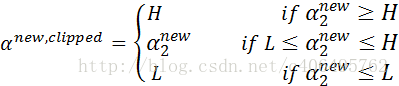

In [3]:
#aj:alpha_j的值
#H:alpha的上限
#L:alpha的下限
def clipAlpha(aj, H, L):
    if aj > H:
        aj = H
    if aj < L:
        aj = L
    return aj

### step.1 计算误差函数
$E_i = f(x_i)-y_i=\sum_{j=1}^na_jy_jx_i^Tx_j+b-y_i$

### step.2 计算上下界L和H，选择alpha
$L = max(0, \alpha_j^{old}-a_i^{old}), H = \min(C, C+\alpha_j^{old} - \alpha_i^{old})  if y_i != y_j$
##### 
$L = max(0, \alpha_j^{old}+a_i^{old}-C), H = \min(C, \alpha_j^{old} + \alpha_i^{old})  if y_i = y_j $

### step.3计算η
$\eta = x_i^Tx_i + x_j^Tx_j - 2x_i^Tx_j$

### step.4 更新α_i
$\alpha_j^{new} = a_j^{old} + \frac{y_i(E_i-E_j)}{\eta}$

### step.6 更新α_i
$\alpha_i^{new} = a_i^{old} + y_iy_j(\alpha_j^{old}-\alpha_j^{new,clipped})$

### step.7更新b_1和b_2
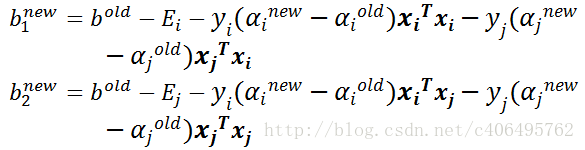

### step.8 根据b_1和b_2更新b
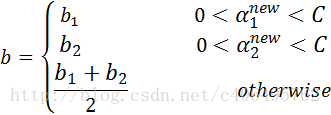

In [4]:
def smoSimple(dataMatIn, classLables, C, toler, max_iter):
    #转化为矩阵
    X = np.mat(dataMatIn)
    labelMat = np.mat(classLables).transpose()
    #初始化b
    b = 0
    #记下dataMatIn的维度
    m, n = np.shape(X)
    #初始化alpha
    alphas = np.mat(np.zeros((m, 1)))
    #初始化迭代次数
    iter_num = 0
    #step.1计算误差Ei
    while iter_num < max_iter:
        alphaPairsChanged = 0
        for i in range(m):
            fXi = float(np.multiply(alphas, labelMat).T * (X * X[i, :].T)) + b
            Ei = fXi - float(labelMat[i])
            #优化alpha,设定容错率
            if ((labelMat[i] * Ei < -toler) and (alphas[i] < C)) or ((labelMat[i] * Ei > toler) and (alphas[i] > 0)):
                j = selectJrand(i, m)
                #计算误差Ej
                fXj = float(np.multiply(alphas, labelMat).T * (X * X[j, :].T)) + b
                Ej = fXj - float(labelMat[j])
                #保存更新前alpha的值
                alphaIold = alphas[i].copy()
                alphaJold = alphas[j].copy()
                #step.2计算上下界L和H  n 
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if (H == L):
                    print('H == L')
                    continue
                #step.3计算eta
                eta = 2.0 * X[i, :]* X[j, :].T - X[i, :] * X[i, :].T - X[j, :] * X[j, :].T
                print(eta)
                #eta = X[i, :] * X[i, :].T + X[j, :] * X[j, :].T - 2.0 * X[i, :].T * X[j, :]
                if eta >= 0:
                    print("eta >= 0")
                    continue
                #step.4更新alpha_j
                alphas[j] -= labelMat[j] * (Ei - Ej)/eta
                #step.5修剪alpha_j
                alphas[j] = clipAlpha(alphas[j], H, L)
                print(alphas[j])
#                 if (abs(alphas[j] - alphaJold) < 0.00001):
#                     print("alpha_j变化太小")
#                     continue
                #step.6更新alpha_i
                alphas[i] += labelMat[j] * labelMat[i] * (alphaJold - alphas[j])
                #step.7更新b_1和b_2
                b1 = b - Ei - labelMat[i] * (alphas[i] - alphaIold) * X[i,:] * X[i,:].T - labelMat[j] * (alphas[j] - alphaJold) * X[i,:] * X[j,:].T
                b2 = b - Ej - labelMat[i] * (alphas[i] - alphaIold) * X[i,:] * X[j,:].T - labelMat[j] * (alphas[j] - alphaJold) * X[j,:] * X[j,:].T
                #step.8根据b_1和b_2更新b
                if (0 < alphas[i]) and (C > alphas[i]): 
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): 
                    b = b2
                else: 
                    b = (b1 + b2) / 2.0
                alphaPairsChanged += 1
                print("第%d次迭代 样本:%d, alpha优化次数:%d" % (iter_num,i,alphaPairsChanged))
        if(alphaPairsChanged == 0):
            iter_num += 1
        else:
            iter_num = 0
        print("迭代次数: %d" % iter_num)
    return b, alphas

In [5]:
def get_w(dataMat, labelMat, alphas):
    alphas, dataMat, labelMat = np.array(alphas), np.array(dataMat), np.array(labelMat)
    w = np.dot((np.tile(labelMat.reshape(1, -1).T, (1, 4)) * dataMat).T, alphas)
    return w.tolist()

In [13]:
if __name__ == '__main__':
    bill_authentication = pd.read_csv(r'bill_authentication.csv')
    attributes = ['Variance', 'Skewness', 'Curtosis', 'Entropy']
    data = bill_authentication[attributes].values
    target = bill_authentication['Class'].values
    label = []
    for i in target:
        if i == 1:
            label.append(1)
        else:
            label.append(-1)
    
    X_train,X_test,y_train,y_test = train_test_split(data, label, test_size=0.9, random_state=0)
    
    b, alphas = smoSimple(X_train, y_train, 0.6, 0.001, 40)
    w = get_w(X_train, y_train, alphas)

H == L
H == L
[[-427.30040484]]
[[0.00468055]]
第0次迭代 样本:2, alpha优化次数:1
[[-297.11878972]]
[[0.00136503]]
第0次迭代 样本:3, alpha优化次数:2
H == L
H == L
H == L
[[-34.66110692]]
[[0.05187874]]
第0次迭代 样本:9, alpha优化次数:3
H == L
H == L
[[-47.03513789]]
[[0.04623303]]
第0次迭代 样本:12, alpha优化次数:4
[[-263.11620937]]
[[0.00495344]]
第0次迭代 样本:15, alpha优化次数:5
[[-143.23738089]]
[[0.00737567]]
第0次迭代 样本:16, alpha优化次数:6
[[-23.21856868]]
[[0.]]
第0次迭代 样本:18, alpha优化次数:7
[[-3.47829724]]
[[0.]]
第0次迭代 样本:22, alpha优化次数:8
[[-338.34231769]]
[[0.0068753]]
第0次迭代 样本:25, alpha优化次数:9
[[-99.22744129]]
[[0.01956321]]
第0次迭代 样本:27, alpha优化次数:10
H == L
H == L
[[-51.84082211]]
[[0.00961425]]
第0次迭代 样本:33, alpha优化次数:11
[[-47.73263706]]
[[0.01956321]]
第0次迭代 样本:34, alpha优化次数:12
[[-32.01959463]]
[[0.05187874]]
第0次迭代 样本:35, alpha优化次数:13
H == L
[[-203.50185622]]
[[0.]]
第0次迭代 样本:41, alpha优化次数:14
H == L
H == L
H == L
H == L
[[-222.46724785]]
[[0.01007214]]
第0次迭代 样本:47, alpha优化次数:15
[[-205.47910064]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:16
[[-184.12281

[[-43.21544341]]
[[0.02554896]]
第0次迭代 样本:129, alpha优化次数:48
[[-180.20173479]]
[[0.]]
第0次迭代 样本:131, alpha优化次数:49
[[-4.54132991]]
[[0.04388147]]
第0次迭代 样本:134, alpha优化次数:50
迭代次数: 0
[[-36.40093047]]
[[0.]]
第0次迭代 样本:1, alpha优化次数:1
[[-368.99574573]]
[[0.00513551]]
第0次迭代 样本:4, alpha优化次数:2
[[-330.77827227]]
[[3.00954917e-05]]
第0次迭代 样本:6, alpha优化次数:3
[[-610.41599939]]
[[0.]]
第0次迭代 样本:7, alpha优化次数:4
[[-128.40669991]]
[[0.00105376]]
第0次迭代 样本:8, alpha优化次数:5
[[-177.23275076]]
[[0.00688026]]
第0次迭代 样本:11, alpha优化次数:6
[[-25.68211189]]
[[0.00026836]]
第0次迭代 样本:12, alpha优化次数:7
[[-43.85016674]]
[[0.01786805]]
第0次迭代 样本:13, alpha优化次数:8
[[-12.32782748]]
[[0.]]
第0次迭代 样本:14, alpha优化次数:9
[[-95.8890079]]
[[0.09295074]]
第0次迭代 样本:16, alpha优化次数:10
[[-29.02680159]]
[[0.00468055]]
第0次迭代 样本:18, alpha优化次数:11
[[-13.57298414]]
[[0.]]
第0次迭代 样本:19, alpha优化次数:12
[[-429.68100074]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:13
[[-312.76049161]]
[[0.03119767]]
第0次迭代 样本:24, alpha优化次数:14
[[-190.08502386]]
[[0.04768674]]
第0次迭代 样本:25, alpha优化次数

[[-81.91370398]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:19
[[-147.22558414]]
[[0.03907386]]
第0次迭代 样本:50, alpha优化次数:20
[[-43.81699329]]
[[0.]]
第0次迭代 样本:58, alpha优化次数:21
[[-143.05810443]]
[[0.03758329]]
第0次迭代 样本:61, alpha优化次数:22
[[-252.87549424]]
[[0.03510102]]
第0次迭代 样本:74, alpha优化次数:23
[[-212.39827483]]
[[0.]]
第0次迭代 样本:80, alpha优化次数:24
[[-139.27417726]]
[[0.]]
第0次迭代 样本:83, alpha优化次数:25
[[-127.44408273]]
[[0.]]
第0次迭代 样本:86, alpha优化次数:26
[[-655.32990631]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:27
[[-100.30569633]]
[[0.]]
第0次迭代 样本:94, alpha优化次数:28
[[-42.32320195]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:29
[[-61.42918688]]
[[0.]]
第0次迭代 样本:105, alpha优化次数:30
[[-42.11464195]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:31
[[-8.96258307]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:32
[[-25.23785213]]
[[0.03510102]]
第0次迭代 样本:122, alpha优化次数:33
H == L
[[-54.11839872]]
[[0.]]
第0次迭代 样本:126, alpha优化次数:34
[[-56.98823932]]
[[0.00268408]]
第0次迭代 样本:128, alpha优化次数:35
[[-267.19734845]]
[[0.]]
第0次迭代 样本:129, alpha优化次数:36
[[-94.1735691]]
[[0.]]
第0次迭代 样本:131, 

[[-32.36539918]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:11
[[-116.75816854]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:12
[[-114.89198785]]
[[0.11675961]]
第0次迭代 样本:44, alpha优化次数:13
[[-122.45165371]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:14
[[-269.83522751]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:15
[[-214.52145642]]
[[0.]]
第0次迭代 样本:50, alpha优化次数:16
[[-88.86598937]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:17
[[-54.57423413]]
[[0.]]
第0次迭代 样本:58, alpha优化次数:18
[[-315.07691224]]
[[0.]]
第0次迭代 样本:74, alpha优化次数:19
[[-198.96236638]]
[[0.]]
第0次迭代 样本:79, alpha优化次数:20
[[-50.24826004]]
[[0.04792696]]
第0次迭代 样本:83, alpha优化次数:21
[[-613.44267779]]
[[0.]]
第0次迭代 样本:86, alpha优化次数:22
[[-83.98704476]]
[[0.]]
第0次迭代 样本:87, alpha优化次数:23
[[-18.78733341]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:24
[[-34.35161031]]
[[0.07997121]]
第0次迭代 样本:94, alpha优化次数:25
[[-94.63531606]]
[[0.]]
第0次迭代 样本:100, alpha优化次数:26
[[-2.48113639]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:27
[[-84.52724393]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:28
[[-123.04298389]]
[[0.00086614]]
第0次迭代 样本:116, alpha优化次数:29
[[-207

[[-54.21225434]]
[[0.]]
第0次迭代 样本:87, alpha优化次数:18
[[-319.32043009]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:19
[[-180.3853885]]
[[0.]]
第0次迭代 样本:94, alpha优化次数:20
[[-31.85778808]]
[[0.]]
第0次迭代 样本:100, alpha优化次数:21
[[-14.8193773]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:22
[[-45.82222135]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:23
[[-38.55525653]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:24
[[-303.13961864]]
[[0.]]
第0次迭代 样本:120, alpha优化次数:25
[[-80.54545768]]
[[0.]]
第0次迭代 样本:122, alpha优化次数:26
[[-194.94094418]]
[[0.00389977]]
第0次迭代 样本:125, alpha优化次数:27
[[-462.89382205]]
[[0.00246986]]
第0次迭代 样本:126, alpha优化次数:28
[[-115.0118105]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:29
[[-116.1961225]]
[[0.]]
第0次迭代 样本:129, alpha优化次数:30
[[-239.38009217]]
[[0.0006347]]
第0次迭代 样本:131, alpha优化次数:31
[[-169.31010906]]
[[0.]]
第0次迭代 样本:132, alpha优化次数:32
[[-43.12837746]]
[[0.]]
第0次迭代 样本:135, alpha优化次数:33
迭代次数: 0
[[-119.89885693]]
[[0.]]
第0次迭代 样本:5, alpha优化次数:1
[[-335.54189336]]
[[0.]]
第0次迭代 样本:7, alpha优化次数:2
[[-56.36966886]]
[[0.]]
第0次迭代 样本:12, alpha优化次数:3
[[-6

H == L
迭代次数: 0
[[-160.1387479]]
[[0.]]
第0次迭代 样本:17, alpha优化次数:1
[[-27.88173632]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:2
[[-312.76049161]]
[[0.]]
第0次迭代 样本:32, alpha优化次数:3
[[-184.16746763]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:4
[[-32.93887701]]
[[0.]]
第0次迭代 样本:41, alpha优化次数:5
[[-197.4794187]]
[[0.00828227]]
第0次迭代 样本:42, alpha优化次数:6
[[-50.24288017]]
[[0.15204494]]
第0次迭代 样本:44, alpha优化次数:7
[[-128.48220176]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:8
[[-146.12140758]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:9
[[-201.28777261]]
[[0.]]
第0次迭代 样本:50, alpha优化次数:10
[[-306.85576796]]
[[0.00121512]]
第0次迭代 样本:52, alpha优化次数:11
[[-156.92596024]]
[[0.]]
第0次迭代 样本:58, alpha优化次数:12
[[-16.75064645]]
[[0.00408229]]
第0次迭代 样本:61, alpha优化次数:13
[[-131.11735211]]
[[0.]]
第0次迭代 样本:74, alpha优化次数:14
[[-395.57255649]]
[[0.]]
第0次迭代 样本:79, alpha优化次数:15
[[-90.84636666]]
[[0.15204494]]
第0次迭代 样本:83, alpha优化次数:16
[[-20.34420373]]
[[0.]]
第0次迭代 样本:86, alpha优化次数:17
[[-420.67538225]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:18
[[-42.75184252]]
[[0.]]
第0次迭代 样本:94, alpha优化

[[-11.31084729]]
[[0.]]
第0次迭代 样本:58, alpha优化次数:10
[[-6.18328051]]
[[0.]]
第0次迭代 样本:86, alpha优化次数:11
[[-181.49587997]]
[[0.]]
第0次迭代 样本:87, alpha优化次数:12
[[-45.89802592]]
[[0.]]
第0次迭代 样本:88, alpha优化次数:13
[[-285.11954909]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:14
[[-64.92047469]]
[[0.]]
第0次迭代 样本:94, alpha优化次数:15
[[-110.69568141]]
[[0.]]
第0次迭代 样本:100, alpha优化次数:16
[[-40.65680413]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:17
[[-48.27278806]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:18
[[-8.03111686]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:19
[[-19.2456608]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:20
迭代次数: 0
[[-51.67865822]]
[[8.53809211e-19]]
第0次迭代 样本:15, alpha优化次数:1
[[-192.94269489]]
[[0.]]
第0次迭代 样本:17, alpha优化次数:2
[[-98.11112485]]
[[0.]]
第0次迭代 样本:19, alpha优化次数:3
[[-161.75843245]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:4
[[-60.43159418]]
[[0.]]
第0次迭代 样本:32, alpha优化次数:5
H == L
[[-276.23119481]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:6
[[-162.14090582]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:7
[[-226.09058705]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:8
[[-107.60243666]]
[[0

[[-81.83508369]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:15
[[-60.55448406]]
[[0.]]
第0次迭代 样本:126, alpha优化次数:16
[[-77.0434759]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:17
迭代次数: 0
H == L
[[-102.91638002]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-333.36472825]]
[[0.]]
第0次迭代 样本:24, alpha优化次数:2
[[-338.19898476]]
[[0.]]
第0次迭代 样本:32, alpha优化次数:3
[[-277.48144561]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:4
[[-118.04200004]]
[[0.00917771]]
第0次迭代 样本:44, alpha优化次数:5
[[-198.3153054]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:6
[[-49.63313494]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:7
[[-282.44833304]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:8
[[-143.23644064]]
[[0.]]
第0次迭代 样本:67, alpha优化次数:9
[[-408.17127905]]
[[0.]]
第0次迭代 样本:79, alpha优化次数:10
[[-88.29002402]]
[[0.]]
第0次迭代 样本:80, alpha优化次数:11
H == L
[[-105.13736052]]
[[0.]]
第0次迭代 样本:86, alpha优化次数:12
[[-27.57426487]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:13
[[-16.49808561]]
[[0.]]
第0次迭代 样本:94, alpha优化次数:14
H == L
[[-163.90361635]]
[[0.01751028]]
第0次迭代 样本:103, alpha优化次数:15
[[-73.62440341]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:16


[[-30.78796829]]
[[0.00355547]]
第0次迭代 样本:60, alpha优化次数:8
[[-213.63912615]]
[[0.]]
第0次迭代 样本:86, alpha优化次数:9
[[-30.0534924]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:10
[[-26.01019733]]
[[0.]]
第0次迭代 样本:94, alpha优化次数:11
[[-16.8830351]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:12
[[-91.75596968]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:13
[[-258.53323249]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:14
[[-1.40271827]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:15
迭代次数: 0
[[-17.67839734]]
[[0.]]
第0次迭代 样本:17, alpha优化次数:1
[[-558.34451337]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:2
[[-144.30445884]]
[[0.]]
第0次迭代 样本:32, alpha优化次数:3
[[-17.67938516]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:4
[[-57.6230542]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:5
[[-22.59636389]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:6
[[-49.19560035]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:7
[[-409.10113994]]
[[0.]]
第0次迭代 样本:86, alpha优化次数:8
[[-219.90089224]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:9
[[-53.41182955]]
[[0.]]
第0次迭代 样本:94, alpha优化次数:10
[[-13.28102618]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:11
[[-94.15023351]]
[[0.]]
第0次迭代 样本:108, 

第0次迭代 样本:32, alpha优化次数:3
[[-232.47804067]]
[[0.]]
第0次迭代 样本:41, alpha优化次数:4
[[-123.00279222]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:5
[[-83.48291235]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:6
[[-27.57500673]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:7
[[-269.83522751]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:8
[[-205.42183837]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:9
[[-503.96222958]]
[[0.]]
第0次迭代 样本:86, alpha优化次数:10
[[-326.40397848]]
[[0.08715925]]
第0次迭代 样本:92, alpha优化次数:11
[[-131.53799789]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:12
[[-293.18478777]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:13
[[-8.03111686]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:14
[[-23.27898814]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:15
[[-0.47868389]]
[[0.]]
第0次迭代 样本:129, alpha优化次数:16
[[-43.0019727]]
[[0.]]
第0次迭代 样本:131, alpha优化次数:17
迭代次数: 0
[[-360.63028816]]
[[0.]]
第0次迭代 样本:17, alpha优化次数:1
[[-132.64303081]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:2
[[-51.59184776]]
[[0.]]
第0次迭代 样本:32, alpha优化次数:3
[[-22.0314772]]
[[0.00274259]]
第0次迭代 样本:41, alpha优化次数:4
[[-569.41706379]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:5

[[-70.57542104]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:9
[[-46.87068835]]
[[0.]]
第0次迭代 样本:83, alpha优化次数:10
[[-629.23294511]]
[[0.]]
第0次迭代 样本:86, alpha优化次数:11
H == L
[[-197.4794187]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:12
[[-79.75714753]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:13
[[-127.37841109]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:14
[[-5.45291498]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:15
[[-26.28111545]]
[[0.001823]]
第0次迭代 样本:128, alpha优化次数:16
H == L
迭代次数: 0
[[-238.92806522]]
[[0.05376866]]
第0次迭代 样本:12, alpha优化次数:1
[[-17.67839734]]
[[0.]]
第0次迭代 样本:17, alpha优化次数:2
[[-82.97999481]]
[[0.]]
第0次迭代 样本:19, alpha优化次数:3
[[-375.38645496]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:4
[[-21.15681723]]
[[0.]]
第0次迭代 样本:32, alpha优化次数:5
H == L
[[-70.17323171]]
[[0.]]
第0次迭代 样本:41, alpha优化次数:6
[[-121.92597655]]
[[0.09337132]]
第0次迭代 样本:43, alpha优化次数:7
[[-28.8861162]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:8
[[-87.15781131]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:9
[[-67.77705111]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:10
[[-117.23120965]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:11
[

[[-96.55679208]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:14
[[-5.45291498]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:15
[[-160.97109786]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:16
迭代次数: 0
[[-91.85390488]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-45.49020385]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:2
[[-158.22826847]]
[[0.09080898]]
第0次迭代 样本:41, alpha优化次数:3
[[-47.66599583]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:4
[[-168.07313532]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:5
[[-81.91370398]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:6
[[-100.59156696]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:7
[[-395.57255649]]
[[0.]]
第0次迭代 样本:79, alpha优化次数:8
[[-105.51149135]]
[[0.]]
第0次迭代 样本:80, alpha优化次数:9
[[-42.17844057]]
[[0.]]
第0次迭代 样本:83, alpha优化次数:10
[[-336.46847101]]
[[0.]]
第0次迭代 样本:86, alpha优化次数:11
[[-471.48028122]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:12
[[-168.1192105]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:13
[[-133.15406745]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:14
[[-17.17508152]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:15
迭代次数: 0
[[-98.30654191]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-141.70631851]]
[[0.

[[-184.95570449]]
[[0.00275722]]
第0次迭代 样本:75, alpha优化次数:13
[[-544.12713321]]
[[0.]]
第0次迭代 样本:79, alpha优化次数:14
[[-132.1990629]]
[[5.30843334e-05]]
第0次迭代 样本:80, alpha优化次数:15
H == L
[[-56.37467066]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:16
[[-0.12987577]]
[[5.30843334e-05]]
第0次迭代 样本:100, alpha优化次数:17
[[-24.05661737]]
[[0.00240594]]
第0次迭代 样本:103, alpha优化次数:18
[[-139.25972472]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:19
[[-19.87295543]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:20
[[-133.61747414]]
[[0.00233873]]
第0次迭代 样本:125, alpha优化次数:21
[[-14.34192705]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:22
[[-149.07894971]]
[[0.]]
第0次迭代 样本:129, alpha优化次数:23
[[-89.69666499]]
[[0.]]
第0次迭代 样本:131, alpha优化次数:24
H == L
[[-89.19693774]]
[[0.]]
第0次迭代 样本:136, alpha优化次数:25
迭代次数: 0
[[-61.75776944]]
[[0.]]
第0次迭代 样本:1, alpha优化次数:1
H == L
[[-271.96913597]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:2
[[-29.97963714]]
[[0.]]
第0次迭代 样本:21, alpha优化次数:3
[[-64.99397279]]
[[0.27212615]]
第0次迭代 样本:24, alpha优化次数:4
[[-232.1067347]]
[[0.00080043]]
第0次迭代 样本:25, alpha优化次数:5

[[-160.62056669]]
[[0.00067665]]
第0次迭代 样本:17, alpha优化次数:1
[[-399.07073854]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:2
[[-474.06612693]]
[[0.]]
第0次迭代 样本:25, alpha优化次数:3
[[-294.42520776]]
[[0.]]
第0次迭代 样本:32, alpha优化次数:4
[[-51.84082211]]
[[0.]]
第0次迭代 样本:33, alpha优化次数:5
[[-218.58119082]]
[[0.06811171]]
第0次迭代 样本:44, alpha优化次数:6
[[-47.28175609]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:7
[[-16.77655159]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:8
[[-284.40280738]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:9
[[-129.43106143]]
[[0.06801679]]
第0次迭代 样本:58, alpha优化次数:10
[[-307.63977417]]
[[0.]]
第0次迭代 样本:61, alpha优化次数:11
[[-72.03851996]]
[[0.]]
第0次迭代 样本:67, alpha优化次数:12
H == L
H == L
[[-260.09130285]]
[[0.00554539]]
第0次迭代 样本:86, alpha优化次数:13
[[-326.40397848]]
[[0.04923753]]
第0次迭代 样本:92, alpha优化次数:14
[[-20.10471613]]
[[0.]]
第0次迭代 样本:100, alpha优化次数:15
[[-2.48113639]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:16
[[-116.84484268]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:17
[[-123.04298389]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:18
[[-60.05225759]]
[[0.]]
第0次迭代 样本:125, al

第0次迭代 样本:39, alpha优化次数:3
[[-161.14163896]]
[[0.04311155]]
第0次迭代 样本:44, alpha优化次数:4
[[-22.13199106]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:5
[[-80.2116079]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:6
[[-150.80512049]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:7
[[-37.75162345]]
[[0.]]
第0次迭代 样本:58, alpha优化次数:8
[[-309.81775488]]
[[0.]]
第0次迭代 样本:79, alpha优化次数:9
[[-42.17844057]]
[[0.]]
第0次迭代 样本:83, alpha优化次数:10
[[-405.57418507]]
[[0.]]
第0次迭代 样本:86, alpha优化次数:11
[[-451.73613186]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:12
[[-109.02924204]]
[[0.]]
第0次迭代 样本:100, alpha优化次数:13
[[-342.46232358]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:14
[[-60.8832776]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:15
[[-28.38865327]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:16
[[-92.34342043]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:17
[[-182.19263458]]
[[0.]]
第0次迭代 样本:132, alpha优化次数:18
迭代次数: 0
[[-36.11600624]]
[[0.]]
第0次迭代 样本:17, alpha优化次数:1
[[-165.88985748]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:2
[[-124.04094477]]
[[0.]]
第0次迭代 样本:32, alpha优化次数:3
[[-81.92097991]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:4
[[-13

[[-270.10322502]]
[[0.00023452]]
第0次迭代 样本:131, alpha优化次数:14
迭代次数: 0
[[-248.62163109]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-312.76049161]]
[[0.]]
第0次迭代 样本:32, alpha优化次数:2
[[-45.49020385]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:3
[[-577.76761984]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:4
[[-0.73608237]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:5
[[-217.89585057]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:6
[[-49.63313494]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:7
[[-116.54138687]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:8
[[-194.94094418]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:9
[[-93.92859839]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:10
[[-98.73790057]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:11
[[-38.11788753]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:12
[[-75.07256838]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:13
[[-11.39087737]]
[[0.]]
第0次迭代 样本:131, alpha优化次数:14
迭代次数: 0
[[-262.79350518]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-33.85294399]]
[[0.]]
第0次迭代 样本:32, alpha优化次数:2
[[-38.98423773]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:3
[[-224.32217832]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:4
[[-30.60396187]]
[[0.]]
第

第0次迭代 样本:47, alpha优化次数:10
[[-236.97461855]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:11
H == L
[[-76.97042681]]
[[0.03133429]]
第0次迭代 样本:74, alpha优化次数:12
[[-102.61043654]]
[[0.]]
第0次迭代 样本:79, alpha优化次数:13
[[-451.97895016]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:14
H == L
[[-163.90361635]]
[[0.02943703]]
第0次迭代 样本:103, alpha优化次数:15
[[-48.76101902]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:16
[[-258.53323249]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:17
[[-23.74750045]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:18
[[-11.39087737]]
[[0.]]
第0次迭代 样本:131, alpha优化次数:19
迭代次数: 0
[[-8.28028282]]
[[0.]]
第0次迭代 样本:11, alpha优化次数:1
[[-375.38645496]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:2
[[-69.58967464]]
[[0.]]
第0次迭代 样本:32, alpha优化次数:3
[[-188.48023565]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:4
[[-111.32655102]]
[[0.]]
第0次迭代 样本:41, alpha优化次数:5
[[-601.04925781]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:6
[[-92.16241949]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:7
[[-12.21036354]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:8
[[-29.60661904]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:9
[[-14.2251225]]
[[0.]]
第0次迭代 样本:

[[-149.60357102]]
[[0.]]
第0次迭代 样本:61, alpha优化次数:9
[[-26.84602712]]
[[0.]]
第0次迭代 样本:79, alpha优化次数:10
[[-190.53535271]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:11
[[-18.4341876]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:12
[[-103.52389263]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:13
[[-4.77600644]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:14
[[-19.00429989]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:15
[[-51.14530634]]
[[0.]]
第0次迭代 样本:132, alpha优化次数:16
迭代次数: 0
[[-20.39265561]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-14.53313564]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:2
[[-53.6584922]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:3
[[-43.70927704]]
[[0.02998701]]
第0次迭代 样本:44, alpha优化次数:4
[[-53.11051223]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:5
[[-34.79726138]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:6
[[-252.50984179]]
[[0.]]
第0次迭代 样本:50, alpha优化次数:7
[[-129.43106143]]
[[0.00067326]]
第0次迭代 样本:52, alpha优化次数:8
[[-22.95700235]]
[[0.03206393]]
第0次迭代 样本:53, alpha优化次数:9
[[-36.99795621]]
[[0.]]
第0次迭代 样本:58, alpha优化次数:10
[[-158.45351882]]
[[0.]]
第0次迭代 样本:60, alpha优化次数:11
[[-31.77958691]]
[[0

第0次迭代 样本:116, alpha优化次数:16
[[-215.65299932]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:17
[[-64.1960479]]
[[0.]]
第0次迭代 样本:132, alpha优化次数:18
迭代次数: 0
H == L
[[-95.29075727]]
[[1.2468325e-18]]
第0次迭代 样本:10, alpha优化次数:1
[[-46.36101733]]
[[0.3168968]]
第0次迭代 样本:11, alpha优化次数:2
H == L
[[-169.0190652]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:3
[[-141.8728279]]
[[0.]]
第0次迭代 样本:32, alpha优化次数:4
[[-22.57841027]]
[[1.2468325e-18]]
第0次迭代 样本:39, alpha优化次数:5
[[-44.60641923]]
[[0.]]
第0次迭代 样本:42, alpha优化次数:6
[[-318.51135162]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:7
[[-63.01195723]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:8
[[-41.59772236]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:9
[[-60.82711189]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:10
[[-233.04234832]]
[[0.00231624]]
第0次迭代 样本:52, alpha优化次数:11
[[-584.71144918]]
[[0.]]
第0次迭代 样本:61, alpha优化次数:12
H == L
[[-705.60190081]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:13
[[-175.41905475]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:14
[[-404.96536214]]
[[0.00108064]]
第0次迭代 样本:108, alpha优化次数:15
[[-63.84166545]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:

第0次迭代 样本:20, alpha优化次数:4
[[-98.48133645]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:5
[[-52.09530387]]
[[0.]]
第0次迭代 样本:42, alpha优化次数:6
[[-23.12393247]]
[[0.00563443]]
第0次迭代 样本:44, alpha优化次数:7
[[-72.82888723]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:8
[[-28.37461707]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:9
[[-208.75987762]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:10
[[-59.62467582]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:11
[[-15.8240628]]
[[0.]]
第0次迭代 样本:94, alpha优化次数:12
H == L
[[-143.78034271]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:13
[[-48.74160965]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:14
[[-8.99863079]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:15
[[-34.35161031]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:16
迭代次数: 0
[[-13.01004025]]
[[0.01620272]]
第0次迭代 样本:11, alpha优化次数:1
[[-167.20700276]]
[[0.]]
第0次迭代 样本:17, alpha优化次数:2
[[-219.4347527]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:3
[[-14.3248444]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:4
[[-162.77444734]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:5
[[-122.45165371]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:6
[[-222.46724785]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:7

[[-30.0534924]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:11
[[-13.63777891]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:12
[[-113.59706585]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:13
[[-81.83508369]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:14
[[-177.44931996]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:15
[[-20.1101348]]
[[0.27348038]]
第0次迭代 样本:132, alpha优化次数:16
迭代次数: 0
[[-71.59011109]]
[[0.]]
第0次迭代 样本:17, alpha优化次数:1
[[-17.68527479]]
[[0.0009676]]
第0次迭代 样本:19, alpha优化次数:2
[[-283.31951405]]
[[0.34786649]]
第0次迭代 样本:20, alpha优化次数:3
[[-212.17521513]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:4
[[-52.85263424]]
[[0.]]
第0次迭代 样本:41, alpha优化次数:5
[[-90.15980468]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:6
[[-17.9944554]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:7
[[-305.46721727]]
[[0.00015705]]
第0次迭代 样本:47, alpha优化次数:8
[[-35.05594136]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:9
[[-394.87628471]]
[[0.]]
第0次迭代 样本:61, alpha优化次数:10
[[-531.86446663]]
[[0.]]
第0次迭代 样本:79, alpha优化次数:11
[[-49.8327409]]
[[0.]]
第0次迭代 样本:83, alpha优化次数:12
[[-136.54204779]]
[[0.]]
第0次迭代 样本:86, alpha优化次数:13
[[-223.6286

[[-116.91222691]]
[[0.00078219]]
第0次迭代 样本:52, alpha优化次数:7
[[-132.34065509]]
[[0.]]
第0次迭代 样本:80, alpha优化次数:8
H == L
[[-451.97895016]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:9
[[-22.28203979]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:10
[[-162.17603447]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:11
[[-42.16646212]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:12
[[-215.65299932]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:13
[[-74.30712731]]
[[0.]]
第0次迭代 样本:131, alpha优化次数:14
迭代次数: 0
[[-111.40382933]]
[[0.]]
第0次迭代 样本:17, alpha优化次数:1
[[-564.03806849]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:2
[[-20.73326555]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:3
[[-0.73608237]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:4
[[-286.96238149]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:5
[[-41.02210671]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:6
[[-49.19560035]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:7
[[-90.23365757]]
[[0.]]
第0次迭代 样本:80, alpha优化次数:8
[[-361.90980851]]
[[0.]]
第0次迭代 样本:86, alpha优化次数:9
[[-223.62864971]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:10
[[-42.01945785]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:11
[[-38.84181801]]
[[0.]]


[[-56.51437512]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:8
[[-2.66644371]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:9
[[-52.54901835]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:10
[[-152.86967273]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:11
[[-157.81972963]]
[[0.]]
第0次迭代 样本:132, alpha优化次数:12
迭代次数: 0
[[-168.32822305]]
[[0.]]
第0次迭代 样本:17, alpha优化次数:1
[[-163.90361635]]
[[0.05726748]]
第0次迭代 样本:20, alpha优化次数:2
[[-33.83531428]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:3
[[-25.65058799]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:4
[[-22.42701988]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:5
[[-49.63313494]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:6
[[-29.11434244]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:7
[[-352.15605748]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:8
[[-184.4977238]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:9
[[-339.29057135]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:10
[[-16.69416034]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:11
[[-350.05638622]]
[[0.]]
第0次迭代 样本:132, alpha优化次数:12
迭代次数: 0
[[-556.5808999]]
[[0.]]
第0次迭代 样本:17, alpha优化次数:1
[[-29.34229089]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:2
[[-97.75084282]]
[[0.]]
第

H == L
H == L
[[-118.62521544]]
[[0.]]
第0次迭代 样本:74, alpha优化次数:7
[[-490.63075559]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:8
[[-7.66006495]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:9
[[-298.88798357]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:10
[[-185.21843897]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:11
[[-38.18057423]]
[[0.]]
第0次迭代 样本:132, alpha优化次数:12
迭代次数: 0
[[-98.79212436]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-2.19445529]]
[[0.38604407]]
第0次迭代 样本:39, alpha优化次数:2
[[-15.1740201]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:3
[[-196.76996]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:4
[[-33.89982575]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:5
H == L
[[-120.5749574]]
[[0.]]
第0次迭代 样本:61, alpha优化次数:6
[[-236.34748239]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:7
[[-61.70445175]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:8
[[-60.8832776]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:9
[[-30.68727127]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:10
[[-93.74035669]]
[[0.02819328]]
第0次迭代 样本:132, alpha优化次数:11
迭代次数: 0
H == L
[[-69.85101278]]
[[0.02768172]]
第0次迭代 样本:20, alpha优化次数:1
[[-65.8474336]]
[[1.45283091e-17]]
第0次

第0次迭代 样本:46, alpha优化次数:7
[[-20.1775002]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:8
[[-41.89021185]]
[[0.]]
第0次迭代 样本:67, alpha优化次数:9
[[-26.5340067]]
[[0.]]
第0次迭代 样本:83, alpha优化次数:10
[[-364.51878451]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:11
[[-32.07580021]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:12
[[-108.19297481]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:13
[[-45.26217105]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:14
[[-134.5178647]]
[[0.]]
第0次迭代 样本:132, alpha优化次数:15
迭代次数: 0
[[-169.0190652]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-98.48133645]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:2
[[-115.35190035]]
[[0.]]
第0次迭代 样本:41, alpha优化次数:3
[[-189.31358358]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:4
[[-25.00067357]]
[[0.01869099]]
第0次迭代 样本:44, alpha优化次数:5
[[-55.37567805]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:6
[[-284.43985262]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:7
[[-490.63075559]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:8
[[-178.82666824]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:9
[[-173.87463868]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:10
[[-60.65791319]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:11
[[-21.3

第0次迭代 样本:103, alpha优化次数:10
[[-94.15023351]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:11
[[-27.2152538]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:12
[[-59.69034509]]
[[0.]]
第0次迭代 样本:132, alpha优化次数:13
迭代次数: 0
H == L
[[-11.05337269]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-6.74218502]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:2
[[-222.03817383]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:3
[[-135.08891788]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:4
[[-189.08601834]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:5
[[-52.43466832]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:6
[[-152.12469332]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:7
[[-613.44267779]]
[[0.]]
第0次迭代 样本:86, alpha优化次数:8
[[-224.33405154]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:9
[[-167.78559832]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:10
[[-43.85016674]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:11
[[-88.62138057]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:12
[[-163.12918216]]
[[0.]]
第0次迭代 样本:132, alpha优化次数:13
迭代次数: 0
[[-298.29090085]]
[[0.35594025]]
第0次迭代 样本:17, alpha优化次数:1
[[-262.79350518]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:2
[[-249.52054264]]
[[0.]]
第0次迭代 样本:39, 

[[-373.12557796]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:7
[[-54.31700281]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:8
[[-33.25712835]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:9
[[-31.5564582]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:10
[[-238.92806522]]
[[3.34672867e-05]]
第0次迭代 样本:52, alpha优化次数:11
[[-175.22203229]]
[[1.08420217e-19]]
第0次迭代 样本:74, alpha优化次数:12
[[-270.32555025]]
[[0.]]
第0次迭代 样本:79, alpha优化次数:13
H == L
[[-227.25636788]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:14
[[-131.53799789]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:15
[[-406.26229613]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:16
[[-97.47893955]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:17
[[-27.23223815]]
[[0.]]
第0次迭代 样本:132, alpha优化次数:18
迭代次数: 0
[[-34.92547105]]
[[0.]]
第0次迭代 样本:11, alpha优化次数:1
[[-59.40743904]]
[[0.]]
第0次迭代 样本:12, alpha优化次数:2
[[-501.66046018]]
[[0.]]
第0次迭代 样本:17, alpha优化次数:3
[[-280.22655516]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:4
[[-44.01493078]]
[[0.]]
第0次迭代 样本:32, alpha优化次数:5
[[-68.26307364]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:6
[[-121.81820276]]
[[0.]]
第0次迭代 样本:41, alpha优化次数:7
[[-271.1

第0次迭代 样本:41, alpha优化次数:4
[[-65.08711385]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:5
[[-217.89585057]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:6
[[-145.99751273]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:7
[[-80.43122204]]
[[0.]]
第0次迭代 样本:79, alpha优化次数:8
[[-192.35549925]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:9
[[-21.67054188]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:10
[[-42.65508419]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:11
[[-32.49224025]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:12
[[-27.63592265]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:13
[[-19.62901077]]
[[0.]]
第0次迭代 样本:132, alpha优化次数:14
迭代次数: 0
[[-199.6460457]]
[[0.]]
第0次迭代 样本:17, alpha优化次数:1
[[-368.99574573]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:2
[[-33.83531428]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:3
[[-257.15837381]]
[[0.]]
第0次迭代 样本:41, alpha优化次数:4
[[-87.91969623]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:5
[[-10.01320662]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:6
[[-14.4030284]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:7
[[-110.40030207]]
[[0.]]
第0次迭代 样本:79, alpha优化次数:8
[[-310.09271095]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:9
[[-178.82666824]]
[[

[[-106.0081958]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:8
[[-161.14163896]]
[[0.29127603]]
第0次迭代 样本:108, alpha优化次数:9
[[-19.38087388]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:10
[[-501.63042623]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:11
迭代次数: 0
[[-525.89448204]]
[[0.]]
第0次迭代 样本:17, alpha优化次数:1
[[-380.18630193]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:2
[[-35.0518585]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:3
[[-165.03967235]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:4
[[-162.14090582]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:5
[[-73.93157477]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:6
[[-48.64399278]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:7
[[-72.74487281]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:8
[[-190.53535271]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:9
[[-56.22862235]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:10
[[-246.99960695]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:11
[[-42.16646212]]
[[0.]]
第0次迭代 样本:116, alpha优化次数:12
[[-19.4311941]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:13
迭代次数: 0
[[-91.72741171]]
[[0.]]
第0次迭代 样本:17, alpha优化次数:1
[[-327.7469981]]
[[0.37412176]]
第0次迭代 样本:20, alpha优化次数:2
[[-30.33488107]]


迭代次数: 0
[[-267.00177317]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-56.81660354]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:2
[[-232.31631075]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:3
[[-21.80736796]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:4
[[-437.14052912]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:5
[[-275.06356354]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:6
[[-175.80669395]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:7
[[-69.17612912]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:8
[[-17.45688037]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:9
迭代次数: 0
[[-10.36850665]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-38.6076487]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:2
[[-117.45081293]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:3
[[-261.89440495]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:4
[[-72.74487281]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:5
[[-560.87532505]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:6
[[-32.07580021]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:7
[[-66.3896175]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:8
[[-26.28111545]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:9
迭代次数: 0
[[-239.34725323]]
[[0.00656682]]
第0次迭代 样本:20, alpha优化次数:1
[[-40.4160248]]
[[0.]]
第

[[-98.86331454]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:6
[[-329.10588692]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:7
[[-56.22862235]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:8
[[-49.14820708]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:9
[[-61.2891689]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:10
迭代次数: 0
[[-127.33173489]]
[[0.29571129]]
第0次迭代 样本:20, alpha优化次数:1
[[-22.57841027]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:2
H == L
[[-135.08891788]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:3
[[-73.93157477]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:4
[[-54.16923298]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:5
[[-142.97092358]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:6
[[-482.73924618]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:7
[[-17.78787247]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:8
[[-406.26229613]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:9
[[-62.07469818]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:10
迭代次数: 0
[[-292.445417]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-240.42664471]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:2
[[-61.69953142]]
[[0.]]
第0次迭代 样本:41, alpha优化次数:3
H == L
[[-40.27591005]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:4
[[-14.768934]]
[[0

[[-45.48544711]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:3
[[-14.51087003]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:4
[[-58.53166648]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:5
[[-113.29340251]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:6
[[-308.41331318]]
[[0.00761166]]
第0次迭代 样本:92, alpha优化次数:7
[[-116.81931255]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:8
[[-53.87625864]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:9
[[-17.06966431]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:10
迭代次数: 0
[[-15.25747027]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-308.41331318]]
[[0.01749583]]
第0次迭代 样本:39, alpha优化次数:2
[[-291.58935748]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:3
[[-126.29927912]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:4
[[-31.5564582]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:5
[[-284.43985262]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:6
[[-27.74989553]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:7
[[-93.83463763]]
[[0.]]
第0次迭代 样本:103, alpha优化次数:8
[[-78.83934898]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:9
[[-185.21843897]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:10
迭代次数: 0
[[-92.59278208]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-65.8474336]]
[[0.]]

[[-50.24288017]]
[[0.30368961]]
第0次迭代 样本:128, alpha优化次数:9
迭代次数: 0
[[-192.10865298]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-115.98156704]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:2
[[-4.90964747]]
[[0.01686787]]
第0次迭代 样本:43, alpha优化次数:3
[[-134.80124023]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:4
[[-5.60310222]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:5
[[-256.82046427]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:6
[[-14.2251225]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:7
[[-655.32990631]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:8
[[-98.8591675]]
[[0.02204951]]
第0次迭代 样本:103, alpha优化次数:9
[[-203.62065792]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:10
迭代次数: 0
[[-33.27907762]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-166.32595757]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:2
H == L
[[-101.68797312]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:3
[[-74.23258569]]
[[0.46039011]]
第0次迭代 样本:46, alpha优化次数:4
[[-380.97800654]]
[[0.00016331]]
第0次迭代 样本:47, alpha优化次数:5
[[-152.92094671]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:6
[[-126.79359284]]
[[0.]]
第0次迭代 样本:86, alpha优化次数:7
[[-312.10089138]]
[[0.]]
第0次迭代 样本:92, alpha优

[[-136.37255907]]
[[0.10653549]]
第0次迭代 样本:39, alpha优化次数:2
[[-57.66103903]]
[[0.]]
第0次迭代 样本:41, alpha优化次数:3
[[-15.1740201]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:4
[[-264.19946509]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:5
[[-16.09807883]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:6
[[-47.75706966]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:7
[[-287.62494288]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:8
[[-307.57213836]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:9
[[-21.11630436]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:10
迭代次数: 0
[[-564.03806849]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-127.33784875]]
[[0.]]
第0次迭代 样本:39, alpha优化次数:2
[[-97.34247722]]
[[0.]]
第0次迭代 样本:41, alpha优化次数:3
[[-99.76516382]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:4
[[-55.71541538]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:5
[[-133.01921168]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:6
[[-74.48116735]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:7
[[-267.47590828]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:8
[[-64.22214174]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:9
[[-15.03788902]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:10
迭代次数: 0
[[-28.24835541]]
[[0.]]
第0次迭代 样本

[[-161.14163896]]
[[0.30501553]]
第0次迭代 样本:108, alpha优化次数:8
[[-19.47633921]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:9
迭代次数: 0
[[-11.8223286]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-489.59228064]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:2
[[-23.12393247]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:3
[[-55.92580107]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:4
[[-52.43466832]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:5
[[-88.67783413]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:6
[[-224.33405154]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:7
[[-326.77335649]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:8
[[-30.68727127]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:9
迭代次数: 0
[[-18.11894858]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-318.51135162]]
[[0.]]
第0次迭代 样本:43, alpha优化次数:2
[[-241.28813061]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:3
[[-128.48220176]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:4
[[-16.87640406]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:5
[[-27.37562622]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:6
[[-39.22971279]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:7
[[-57.95560049]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:8
[[-174.10084966]]
[[0.]]
第0次迭代 样本:

[[-60.82711189]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-152.92094671]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-285.11954909]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:5
[[-443.41111552]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:6
[[-14.99841924]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:7
迭代次数: 0
[[-161.75843245]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-69.28164874]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-37.63064742]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-116.91222691]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-317.60094414]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:5
[[-58.58455613]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:6
[[-152.86967273]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:7
迭代次数: 0
[[-88.60015721]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-92.16241949]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-37.63064742]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-238.92806522]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-55.97818615]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:5
[[-297.52360587]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:6
[[-71.03324628]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:7
迭代次数: 0
[[-237.03134962]]
[[0.]]
第0次迭代

[[-107.43629628]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-278.60168258]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-17.06966431]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-601.41980948]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-41.00529317]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-136.34202495]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-89.91707743]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-185.21843897]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-36.83275713]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-114.89198785]]
[[0.30187875]]
第0次迭代 样本:47, alpha优化次数:2
[[-17.1275524]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-293.18478777]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-115.0118105]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-250.67600297]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-241.28813061]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-136.34202495]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-48.27278806]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-56.98823932]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-611.73680038]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-118.7611

[[-71.03324628]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-592.01797885]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-69.93619523]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-222.46724785]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-87.7234826]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-50.8865923]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-69.85101278]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-134.80124023]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-60.82711189]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-49.19560035]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-30.93522404]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-292.445417]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-54.31700281]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-42.3428997]]
[[0.11913068]]
第0次迭代 样本:47, alpha优化次数:3
[[-116.84484268]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-35.84977615]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-169.36466597]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-17.43139208]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-29.60661904]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-278.65848204]]
[[0.]

[[-327.7469981]]
[[0.09114116]]
第0次迭代 样本:47, alpha优化次数:2
[[-13.92845579]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-84.85538673]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-90.84636666]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-98.79212436]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-107.83371709]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-8.30343709]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-180.01132405]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-64.22214174]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-165.10455348]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-375.38645496]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-33.7459705]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-8.16041381]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-42.3428997]]
[[0.41324957]]
第0次迭代 样本:52, alpha优化次数:4
[[-166.54417658]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-14.34192705]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-260.3804238]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-161.14163896]]
[[0.01257747]]
第0次迭代 样本:44, alpha优化次数:2
[[-41.00529317]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-292.653732

[[-92.27007622]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:6
[[-19.47633921]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:7
迭代次数: 0
[[-282.97650634]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-59.32767729]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-54.16923298]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-87.7234826]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-117.73318093]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-14.34192705]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-207.45265761]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-50.24288017]]
[[0.49637841]]
第0次迭代 样本:44, alpha优化次数:2
[[-15.60749142]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-113.29340251]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
H == L
[[-406.26229613]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-185.21843897]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-247.17840873]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-176.81701633]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-108.89495467]]
[[4.28398304e-05]]
第0次迭代 样本:47, alpha优化次数:3
[[-48.93105511]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-364.51878451]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:5
H =

[[0.]]
第0次迭代 样本:46, alpha优化次数:3
[[-58.53166648]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:4
H == L
[[-117.73318093]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-14.34192705]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-368.58365194]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-117.45081293]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-237.24752005]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:3
[[-45.75801835]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:4
[[-272.27385095]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:5
[[-38.1749602]]
[[0.]]
第0次迭代 样本:94, alpha优化次数:6
H == L
[[-45.81516877]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:7
[[-203.62065792]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:8
迭代次数: 0
[[-3.94594517]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-269.94641726]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-22.80474091]]
[[0.]]
第0次迭代 样本:46, alpha优化次数:3
[[-20.01694549]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:4
[[-272.77725896]]
[[0.]]
第0次迭代 样本:92, alpha优化次数:5
H == L
H == L
[[-158.42034823]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:6
[[-16.6325973]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:7
迭代次数: 0
[[-491.42828452]]
[[0.

[[-62.07482556]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-18.91428525]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-192.00249037]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-199.38807864]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-60.65791319]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-235.40442838]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-69.28164874]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-53.963363]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-42.3428997]]
[[0.41784892]]
第0次迭代 样本:52, alpha优化次数:4
[[-53.16286897]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-19.47633921]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-169.0190652]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-222.76419217]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-52.27756324]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:3
[[-56.98823932]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-429.42378364]]
[[0.01133226]]
第0次迭代 样本:20, alpha优化次数:1
[[-162.14090582]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-45.75801835]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-87.7234826]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-91.75596968]]
[[0.

[[-136.55091653]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-52.35039591]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-102.91638002]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-101.49428166]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-38.74044782]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-139.77883091]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-203.87148571]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-28.93521922]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-567.80029346]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-31.11826702]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-29.60661904]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-163.4493321]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-49.14820708]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-19.47633921]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-28.24835541]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-26.49127571]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-49.10988768]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-162.15182059]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-77.9989569]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-58.31623872]]
[[0.]]
第0次迭代 样本

迭代次数: 0
[[-368.99574573]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-233.37821633]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-36.22573022]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-63.03184016]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-180.25785408]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-2.18554396]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-204.53953873]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-23.7088016]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-49.10988768]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-72.74487281]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-176.77700734]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-101.99825763]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-15.25747027]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-15.1740201]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-362.59109444]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-33.22529039]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-60.45456589]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-56.98823932]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-353.2941162]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-107.83371709]]
[[0.]]
第0

[[-166.54417658]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-154.40980226]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-48.7302051]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-41.286187]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-39.39137332]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-101.89384221]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-216.49816825]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-160.97109786]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-89.78485892]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-80.75486495]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-32.85346072]]
[[0.50786364]]
第0次迭代 样本:47, alpha优化次数:3
[[-125.30749776]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-76.60298484]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-14.99841924]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-176.45168176]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-135.08891788]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-120.916707]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-42.3428997]]
[[0.4270998]]
第0次迭代 样本:52, alpha优化次数:4
[[-418.9191962]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-142.24050719]]
[[

[[-62.27944273]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-23.27898814]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-33.27907762]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-113.22579812]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-400.06957983]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-203.38725879]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-338.34231769]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-154.40980226]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-204.18532796]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-58.50089413]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-41.29524908]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-167.10867778]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-91.75596968]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-295.4634327]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-54.45010644]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-28.27446053]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-256.82046427]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-23.70185934]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-297.52360587]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-115.14851388]]
[[0.]]
第0次迭

迭代次数: 0
[[-417.79020151]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-48.64971919]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-49.51788287]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-61.93439376]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-49.14820708]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
迭代次数: 0
[[-11.8223286]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-49.5642768]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-124.69739471]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-290.58792421]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-503.17865489]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
迭代次数: 0
[[-611.73680038]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-47.15323271]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-21.80736796]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-100.59156696]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-162.17603447]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
迭代次数: 0
[[-33.03338765]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-241.20765025]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-49.63313494]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-166.9959134]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-29.34316017]]
[[0.4285832

[[-48.27278806]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-126.10664713]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-204.53953873]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-176.81701633]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-168.51953998]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-437.14052912]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-75.1381977]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-152.86967273]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-48.7302051]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-206.12488681]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-28.37461707]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-30.17825978]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-161.14163896]]
[[0.30792145]]
第0次迭代 样本:108, alpha优化次数:5
[[-9.4927114]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-8.33451606]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-107.28546561]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-29.60661904]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-121.59758114]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-246.99960695]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-139.01822015]]
[[0.]]

[[-39.74326917]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-12.96834818]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-29.11434244]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-246.99960695]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-283.31951405]]
[[0.09126041]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-3.77414872]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-28.37461707]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-48.93105511]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-84.52724393]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-50.8865923]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-20.1101348]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-39.39137332]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-170.16138696]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-418.9191962]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-2.23110147]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-25.65058799]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-51.79968209]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-117.18995694]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-46.94119601]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-46.13395199]]
[[0.]]
第0次迭代 

[[-235.77783658]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-45.26217105]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-292.17928466]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-99.76516382]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-91.97370752]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-292.62631473]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-92.99315679]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-592.01797885]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-339.25903976]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-129.04199886]]
[[0.51285403]]
第0次迭代 样本:52, alpha优化次数:3
[[-204.59610644]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-47.38632082]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-28.24835541]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-113.22579812]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-331.97970547]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-100.59156696]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-59.40270234]]
[[0.12813679]]
第0次迭代 样本:108, alpha优化次数:5
[[-14.34192705]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-207.45265761]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[

[[-102.18154049]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-184.47041798]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-37.63064742]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-107.43629628]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-180.25785408]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-160.97109786]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-139.53618597]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-150.9871877]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-331.97970547]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-234.9663356]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-204.59610644]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-50.24288017]]
[[0.3088499]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-220.66231274]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-102.18028192]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-20.25285218]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-48.93105511]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-42.20377636]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-2.23110147]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-54.45010644]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-102.18028192]]
[[0.]

第0次迭代 样本:52, alpha优化次数:4
[[-113.59706585]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-17.55193331]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-282.97650634]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-50.24288017]]
[[0.51406235]]
第0次迭代 样本:44, alpha优化次数:2
[[-115.05830147]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-282.44833304]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-73.62440341]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-30.21465211]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-280.22655516]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-3.06630348]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-42.81817891]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-371.84976526]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-60.45456589]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-203.62065792]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-380.18630193]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-25.65058799]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-51.56246614]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-134.86382651]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-139.25972472]]
[[0.]]
第0次迭代 样本:108, alpha优化次

第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-292.445417]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-13.40948122]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-15.60749142]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-136.37255907]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-439.09909831]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-40.75139054]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-208.58437668]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-149.90434023]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-51.79968209]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-234.9663356]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-114.75640132]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-165.0662979]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-601.41980948]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-76.52906916]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-261.89440495]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-152.12469332]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-5.56571251]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-25.24288088]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-238.37373908]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:

迭代次数: 0
[[-20.52112087]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-29.34316017]]
[[0.00475574]]
第0次迭代 样本:47, alpha优化次数:2
[[-132.05043946]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-109.57542338]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-97.47893955]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-220.66231274]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-47.66599583]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-55.37567805]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-100.59156696]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-235.77783658]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-92.99315679]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-2.29706382]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-267.91260623]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-28.37461707]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-70.57542104]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-466.93377382]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-60.65791319]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-29.56232829]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-258.67174679]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-226.09058705]

第0次迭代 样本:20, alpha优化次数:1
[[-59.32767729]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-22.59636389]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-9.71639948]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-74.23258569]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-368.99574573]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-1.28735583]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-108.89495467]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-304.78711475]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-28.93521922]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-18.11894858]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-264.36887616]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-32.97899176]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-74.51336889]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-28.93521922]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-368.99574573]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-41.25066911]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-41.02210671]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-152.12469332]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-41.04878294]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-1

[[-293.18478777]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-17.55193331]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-143.25425083]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-23.20469352]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-117.18995694]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-297.52360587]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-275.60515972]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-127.33173489]]
[[0.30789673]]
第0次迭代 样本:20, alpha优化次数:1
[[-30.3523494]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-116.17410604]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-111.16715179]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-56.52201939]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-385.60994784]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-108.54681313]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-203.38725879]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-105.66765628]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-1.40271827]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-243.2292322]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-25.08007429]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-274.1482

[[-165.0662979]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-137.3141867]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-25.65058799]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-133.01921168]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-116.54138687]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-203.87148571]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-92.99315679]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-29.34229089]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-101.68797312]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-241.00813746]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-70.57542104]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-43.34796357]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-21.11630436]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-384.72360391]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-127.33173489]]
[[0.08967367]]
第0次迭代 样本:44, alpha优化次数:2
[[-221.02306894]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-27.85962899]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-103.52389263]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-185.21843897]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-192.10865

迭代次数: 0
[[-49.5642768]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-38.41521621]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-40.7313019]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-246.99960695]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-50.8865923]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-239.08564606]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-223.40456618]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-313.16335093]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-53.16286897]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-160.97109786]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-17.67938516]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-34.79726138]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-98.24286278]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-94.89880386]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-115.14851388]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-3.77414872]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-108.89495467]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-83.40132743]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-117.73318093]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:4
[[-75.07256838]]
[[0.]]
第0

迭代次数: 0
[[-385.60994784]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-47.79810738]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-34.79726138]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-407.55480265]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-65.11178785]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-16.69416034]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-558.34451337]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-267.91260623]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-15.75740875]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-332.76843758]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-42.20377636]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-32.93110722]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-138.31344087]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-127.33173489]]
[[0.08810323]]
第0次迭代 样本:44, alpha优化次数:2
[[-7.56568617]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-14.2251225]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-108.595357]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-92.99315679]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-27.88173632]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-18.16857343]]
[[

第0次迭代 样本:44, alpha优化次数:2
[[-51.45337684]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-406.36687609]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-117.73318093]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-2.18554396]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-14.84856111]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-162.14090582]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-32.85346072]]
[[0.52512924]]
第0次迭代 样本:47, alpha优化次数:3
[[-101.89384221]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-204.59610644]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-160.97109786]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-384.72360391]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-0.73608237]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-52.43466832]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-27.37562622]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-49.14820708]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-30.21465211]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-212.58142178]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-28.27446053]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-55.37567805]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3


[[-665.89151651]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-14.99841924]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-558.34451337]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-97.08169289]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-20.1775002]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-139.77883091]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-216.49816825]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-139.01822015]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-235.40442838]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-127.33173489]]
[[0.08766411]]
第0次迭代 样本:44, alpha优化次数:2
[[-29.60661904]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-284.43985262]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-45.82222135]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-55.59354982]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-88.60015721]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-241.28813061]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-41.02210671]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-351.16855255]]
[[0.08753886]]
第0次迭代 样本:52, alpha优化次数:4
[[-19.43122134]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-53

[[-220.66231274]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-45.48544711]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-145.99751273]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-26.28111545]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-375.38645496]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-34.65718204]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-95.8890079]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-101.99825763]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-102.91638002]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-23.7088016]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-21.80736796]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-6.18289769]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-170.71417073]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-17.43139208]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-332.84076793]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-60.65791319]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-319.49016605]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-50.24288017]]
[[0.52510583]]
第0次迭代 样本:44, alpha优化次数:2
[[-33.89982575]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-128.01023267]]
[[

[[-285.19538347]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-29.56232829]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-29.68437831]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-42.93779715]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-112.06727028]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-0.40665328]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-417.79020151]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-90.15980468]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-21.92682441]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-74.48116735]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-2.23110147]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-191.0995046]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-272.92078332]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-332.84076793]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-203.38725879]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-51.35281201]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-337.76709204]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-42.84679911]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-49.51788287]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-274.14820895]]
[[0.]]
第0次

[[-249.73769618]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-108.89495467]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-205.47910064]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-92.99315679]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-412.32746932]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-99.76516382]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-28.37461707]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-304.78711475]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-170.85372808]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-413.78394395]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-28.27446053]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-41.00529317]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-40.7313019]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-71.03324628]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-283.31951405]]
[[0.52716195]]
第0次迭代 样本:20, alpha优化次数:1
[[-76.52906916]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-19.98482115]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-131.01345414]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-203.62065792]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-41.25066911]]

[[-285.19538347]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-140.2181846]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-113.22579812]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-290.58792421]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-23.74750045]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-109.53312372]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-62.07482556]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-197.03859684]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-51.35281201]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-283.31951405]]
[[0.52710662]]
第0次迭代 样本:20, alpha优化次数:1
[[-69.93619523]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-60.82711189]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-113.29340251]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-2.19445529]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-264.36887616]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-29.34316017]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-136.37255907]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-2.18554396]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-21.46603299]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-20.757

迭代次数: 0
[[-353.2941162]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-206.12488681]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-42.93779715]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-14.2251225]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-48.74160965]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-53.26061523]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-163.90361635]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-21.21604385]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-21.92682441]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-83.40132743]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-53.87625864]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-272.31360902]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-139.53618597]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-53.06749963]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-114.89198785]]
[[0.30565679]]
第0次迭代 样本:47, alpha优化次数:3
[[-128.01023267]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-103.52389263]]
[[0.]]
第0次迭代 样本:108, alpha优化次数:5
[[-50.8865923]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:6
迭代次数: 0
[[-54.45010644]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-40.27591005]]
[

第0次迭代 样本:20, alpha优化次数:1
[[-49.25949574]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-8.30343709]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-274.14820895]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-285.19538347]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-247.17840873]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-107.28546561]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-118.3923363]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-28.84094871]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-180.6879933]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-163.90361635]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-21.21604385]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-132.05236994]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-121.59758114]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-71.03324628]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-10.36850665]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-256.52988451]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-145.99751273]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-107.60243666]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-14.34192705]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0

迭代次数: 0
[[-611.73680038]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-65.08711385]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-58.53166648]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-152.92094671]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-15.03788902]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-262.79350518]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-62.07482556]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-118.3923363]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-339.35193137]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-32.03790509]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-506.54388007]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-267.91260623]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-108.54681313]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-72.74487281]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-215.65299932]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-408.86492782]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-239.08564606]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-30.3523494]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-152.12469332]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-283.31951405]]
[[0.08

迭代次数: 0
[[-267.00177317]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-16.90345925]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-57.33296473]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-304.78711475]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
迭代次数: 0
[[-15.25747027]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-267.42910882]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-154.84028621]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-105.84197136]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
迭代次数: 0
[[-325.97013883]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-204.19372955]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-54.93568627]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-304.78711475]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
迭代次数: 0
[[-98.79212436]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-34.65718204]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-29.34316017]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-88.86598937]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
迭代次数: 0
[[-282.92551792]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-269.94641726]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-58.53166648]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-13.92845579]]
[[

[[-25.00067357]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-286.91138638]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-203.38725879]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-59.42614062]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-92.16241949]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-41.00529317]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-257.20644194]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-56.52201939]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-232.31631075]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-57.33296473]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-116.91222691]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-180.6879933]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-58.50089413]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-54.16923298]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-255.15852889]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-32.93110722]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-118.76116835]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-85.29083846]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-180.01132405]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-55.59354982]]
[[0.]]
第

[[-116.91222691]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-120.66890166]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-558.34451337]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-69.93619523]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-41.29524908]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-35.05594136]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-26.57880475]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-29.56232829]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-97.08169289]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-13.52487677]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-107.61082107]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-52.35039591]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-2.29706382]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-43.70927704]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-154.84028621]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-30.17825978]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-17.06966431]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-169.36466597]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-62.07482556]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-132.05236994]]
[[0.]]
第0次

[[-88.86598937]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-25.24288088]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-144.841582]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-11.88814848]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-152.12469332]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-2.23110147]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-282.97650634]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-54.16923298]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-192.00249037]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-14.99841924]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-368.99574573]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-8.30343709]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-113.29340251]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-242.45720156]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-292.445417]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-18.91428525]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-17.1275524]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-42.48696215]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-238.37373908]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-49.51788287]]
[[0.]

[[-23.70185934]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-216.23054173]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-49.25949574]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-108.54681313]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-13.92845579]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-19.00429989]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-97.76689555]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-305.46721727]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-105.84197136]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-215.65299932]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-28.27446053]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-18.91428525]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-341.74335195]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-28.93521922]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-76.52906916]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-44.08573665]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-203.38725879]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-180.6879933]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-39.88649992]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-269.83522751]]

迭代次数: 0
[[-76.52906916]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-20.1775002]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-351.16855255]]
[[0.08536514]]
第0次迭代 样本:52, alpha优化次数:3
[[-32.03790509]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-2.29706382]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-63.01195723]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-108.54681313]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-341.74335195]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-190.08502386]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-29.56232829]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-43.40716695]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-33.89982575]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-105.84197136]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-9.4927114]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-161.75843245]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-50.84349541]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-8.30343709]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-169.12625754]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-115.0118105]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-89.78485892]

[[-35.5515957]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-222.76419217]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-284.43985262]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-155.04554538]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-212.58142178]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-102.62132095]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-81.08586087]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-98.24286278]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-71.03324628]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-186.28264759]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-239.08564606]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-355.39394598]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-162.15182059]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-35.45391698]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-412.32746932]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-26.49127571]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-400.06957983]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-98.09138799]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-50.24288017]]
[[0.30239307]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-204.18532796

迭代次数: 0
[[-34.65718204]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-12.96834818]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-113.29340251]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-51.35281201]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-269.94641726]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-222.46724785]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-112.06727028]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-98.90672434]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-204.19372955]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-64.89280488]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-87.7234826]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-90.84636666]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-47.79810738]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-95.8890079]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-112.06727028]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-155.04554538]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-0.70595506]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-298.29090085]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-14.2251225]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-34.35161031]]
[[0.

迭代次数: 0
[[-33.03338765]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-31.11826702]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-108.89495467]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-129.04199886]]
[[0.52672946]]
第0次迭代 样本:52, alpha优化次数:4
迭代次数: 0
[[-29.34229089]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-97.76689555]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-46.36101733]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-123.6727408]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
迭代次数: 0
[[-102.18154049]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-54.31700281]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-29.34316017]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-129.04199886]]
[[0.52672946]]
第0次迭代 样本:52, alpha优化次数:4
迭代次数: 0
[[-10.36850665]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-27.89646527]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-145.99751273]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-107.60243666]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
迭代次数: 0
[[-28.24835541]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-2.84685153]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-3.98447306]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-205.47

第0次迭代 样本:47, alpha优化次数:2
[[-112.06727028]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-56.52201939]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-150.9871877]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-49.51788287]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-234.9663356]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-75.4727075]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-339.25903976]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-16.77655159]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-407.55480265]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-237.55627009]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-40.27591005]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-305.46721727]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-437.14052912]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-203.62065792]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-30.04837779]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-42.3428997]]
[[0.14478099]]
第0次迭代 样本:47, alpha优化次数:2
[[-60.65791319]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-5.03945725]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-267.91260623]]
[[0.]]
第0次迭代 样本:44

第0次迭代 样本:44, alpha优化次数:1
[[-49.10988768]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-95.25634659]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-15.03788902]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-147.77007569]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-57.33296473]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-105.84197136]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-148.6149889]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-90.15980468]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-44.08573665]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-70.57542104]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-216.23054173]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-20.1101348]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-39.39137332]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-234.9663356]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-6.18289769]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-258.67174679]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-64.99397279]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-83.40132743]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-16.6325973]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 

[[-384.72360391]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-92.16241949]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-103.97525381]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-242.45720156]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-247.17840873]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-169.23286585]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-116.54138687]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-19.4311941]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-186.28264759]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-26.49127571]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-131.01345414]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-60.53789001]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-124.40320657]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-102.62132095]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-257.20644194]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-40.75139054]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-170.71417073]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-249.73769618]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-170.16138696]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-14.34192705]]
[[0

[[-48.64971919]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-305.46721727]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-284.43985262]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-272.31360902]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-109.53312372]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-27.89646527]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-53.963363]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-129.43106143]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-9.4927114]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-140.2181846]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-28.8861162]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-51.01605578]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-120.66324863]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-45.26217105]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-139.53618597]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-206.12488681]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-34.79726138]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-341.74335195]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-98.90672434]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-601.41980948]]
[[0.]]
第0次迭

[[-161.14163896]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-117.57529314]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-40.7313019]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-118.47860443]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-41.286187]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-29.60661904]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-109.7447376]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-17.55193331]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-28.8861162]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-8.16041381]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-205.42183837]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-275.60515972]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-47.15323271]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-34.79726138]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-140.70970443]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-139.01822015]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-20.40393012]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-261.89440495]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-306.85576796]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-80.84174994]]
[[0.]]
第0次迭代

[[-30.21465211]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-71.61557079]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-362.59109444]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-257.20644194]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-501.63042623]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-60.42226169]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-256.82046427]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-91.97370752]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-60.65791319]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-7.47659184]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-581.65170051]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-17.1275524]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-51.35281201]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-18.82536747]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-62.85397117]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-27.37562622]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-32.93110722]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-49.5642768]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-35.59418633]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-282.44833304]]
[[0.

[[-180.6879933]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-30.60396187]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-15.75740875]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-361.20075995]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-194.37567687]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-58.50089413]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-27.03665264]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-29.11434244]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-83.69641149]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-33.7459705]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-115.4114756]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-74.51336889]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-185.21843897]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-267.91260623]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-10.85433139]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-233.04234832]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-88.62138057]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-58.50089413]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-42.06009414]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-100.59156696]]
[[

[[-37.63064742]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-116.54138687]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-19.00429989]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-21.46603299]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-256.82046427]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-73.91726939]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-14.99841924]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-0.73608237]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-103.99869332]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-105.84197136]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-64.01663914]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-23.7088016]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-51.01605578]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-116.17410604]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-30.22226862]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-97.08169289]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-49.10988768]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-113.29340251]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-177.44931996]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-3.77414872]]
[[0

[[-501.63042623]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-408.86492782]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-57.33296473]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-406.36687609]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-115.0118105]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-199.83775331]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-20.75767947]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-281.81702196]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-15.61450539]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-491.42828452]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-35.59418633]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-42.95190395]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-51.35281201]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-69.85101278]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-37.63064742]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-13.92845579]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-120.66890166]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-11.05337269]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-26.64668001]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-252.28772151]]

[[-178.65868641]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-18.11894858]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-7.7894573]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-112.06727028]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-32.93110722]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-399.07073854]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-30.60396187]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-437.14052912]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-92.34342043]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-353.2941162]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-127.33173489]]
[[0.08419214]]
第0次迭代 样本:44, alpha优化次数:2
[[-42.3428997]]
[[0.14598396]]
第0次迭代 样本:47, alpha优化次数:3
[[-63.78926782]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-101.68797312]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-66.9033594]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-194.37567687]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-39.73924813]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-42.81817891]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-27.63592265]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数

[[-20.1101348]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-25.08007429]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-267.00177317]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-272.92078332]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-3.98447306]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-212.58142178]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-17.67938516]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-37.63064742]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-327.7469981]]
[[0.45701239]]
第0次迭代 样本:20, alpha优化次数:1
[[-92.16241949]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-27.03665264]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-58.31623872]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-238.37373908]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-218.58119082]]
[[0.14600001]]
第0次迭代 样本:44, alpha优化次数:2
[[-222.76419217]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-208.75987762]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-16.49580474]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-98.79212436]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-43.08247996]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-10.

迭代次数: 0
[[-413.78394395]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-15.60749142]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-256.73592511]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
迭代次数: 0
[[-353.2941162]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-12.96834818]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-146.031147]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
迭代次数: 0
[[-161.75843245]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-311.93213456]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-339.35193137]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
迭代次数: 0
[[-20.39265561]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-115.05830147]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-112.06727028]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
迭代次数: 0
[[-212.58142178]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-201.20846366]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-83.40132743]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
迭代次数: 0
[[-325.97013883]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-108.89495467]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-371.84976526]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
迭代次数: 0
[[-368.99574573]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[

第0次迭代 样本:44, alpha优化次数:1
[[-49.10988768]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-132.05043946]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-34.35161031]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-127.33173489]]
[[0.08403694]]
第0次迭代 样本:44, alpha优化次数:1
[[-51.79968209]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-332.76843758]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-215.65299932]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-408.86492782]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-201.20846366]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-112.06727028]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-15.61450539]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-212.58142178]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-79.71259576]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-292.65373266]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-120.66890166]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-412.32746932]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-51.56246614]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-150.80512049]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-165.0662979]]
[[0.]]
第0次迭代 样本:128,

[[-282.97650634]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-21.46603299]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-362.59109444]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-601.41980948]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-0.70595506]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-241.00813746]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-500.51657595]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-249.73769618]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-400.06957983]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-282.97650634]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-102.18028192]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-108.54681313]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-248.62163109]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-102.62132095]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-380.97800654]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-115.58919303]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-34.65718204]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-146.12140758]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-89.78485892]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-26.4

[[-148.6149889]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-31.11826702]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-154.84028621]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-255.15852889]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-17.45688037]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-97.08169289]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-20.25285218]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-35.05594136]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-96.86299133]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-3.06630348]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-96.01416647]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-27.85962899]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-115.0118105]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-224.64806019]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-39.21673767]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-113.54357054]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-30.21465211]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-101.68797312]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-37.63064742]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-170.16138696]]
[[

[[-21.06889519]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-233.04234832]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-142.24050719]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-247.17840873]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-127.16858544]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-117.18995694]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-2.23110147]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-611.73680038]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-45.75801835]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-163.4493321]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-90.84636666]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-169.36466597]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-68.63062982]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-109.7447376]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-190.08502386]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-280.22655516]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-38.74044782]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-88.67783413]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-190.08502386]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-267.00177317

[[-19.2456608]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-13.40948122]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-115.16407287]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:2
[[-53.26061523]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-17.67938516]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-163.4493321]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:2
[[-33.69769999]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-69.28164874]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-42.3428997]]
[[0.45724011]]
第0次迭代 样本:52, alpha优化次数:2
迭代次数: 0
[[-107.02244125]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-162.77444734]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-222.46724785]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-412.32746932]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-28.27446053]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-15.60749142]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-98.30654191]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-87.91969623]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-20.27096018]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-516.02822323]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:

迭代次数: 0
[[-252.00532372]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-0.70595506]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-67.77705111]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-103.97525381]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-25.24288088]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-327.7469981]]
[[0.45734026]]
第0次迭代 样本:20, alpha优化次数:1
[[-18.82536747]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-11.88814848]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-116.91222691]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-50.8865923]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-163.8724999]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-43.70927704]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-55.11214553]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-406.99819173]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-34.35161031]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-98.79212436]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-3.77414872]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-118.3923363]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-129.43106143]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-80.84174994]]
[[0.]]


第0次迭代 样本:44, alpha优化次数:1
[[-45.75801835]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-134.86382651]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-35.45391698]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-39.88649992]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-7.56568617]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-129.43106143]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-2.23110147]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-76.52906916]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-79.71259576]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-47.75706966]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-25.24288088]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-267.91260623]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-25.08007429]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-313.16335093]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-27.63592265]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-43.40716695]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-53.963363]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-123.6727408]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-160.97109786]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 

[[-115.0118105]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-150.9871877]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-74.48116735]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:2
[[-129.04199886]]
[[0.1464612]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-271.96913597]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-117.45081293]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-122.3801308]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-163.8724999]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-17.43139208]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-30.3523494]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-204.53953873]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-241.20765025]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-114.89198785]]
[[0.29922074]]
第0次迭代 样本:47, alpha优化次数:3
[[-136.37255907]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-178.65868641]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-89.28719948]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-2.84685153]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-284.43985262]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-23.74750045]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次

迭代次数: 0
[[-244.97643715]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-39.73924813]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-37.63064742]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-374.9705476]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-2.23110147]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-252.00532372]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-267.91260623]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-66.9033594]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-72.74487281]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-272.31360902]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-92.59278208]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-1.28735583]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-21.80736796]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-125.30749776]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-52.35039591]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-220.66231274]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-29.68437831]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-79.71259576]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-113.29340251]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-45.26217105]]
[[0.]]
第0次迭代 

第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-408.86492782]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-258.67174679]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-80.2116079]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-257.20644194]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-17.55193331]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-238.37373908]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-28.8861162]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-261.89440495]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-407.55480265]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-15.61450539]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-346.63275643]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-28.27446053]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-42.93779715]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-9.71639948]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[-58.31623872]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:5
迭代次数: 0
[[-33.27907762]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-272.92078332]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-38.74044782]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-290.58792421]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:4
[[

第0次迭代 样本:44, alpha优化次数:1
[[-52.43466832]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-2.84685153]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-400.06957983]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-54.31700281]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-67.77705111]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-26.49127571]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-20.01694549]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-232.31631075]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-226.09058705]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-47.66599583]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-145.99751273]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-97.08169289]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-16.77655159]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-206.12488681]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-122.3801308]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-3.77414872]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-20.27096018]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-113.22579812]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-67.17204478]]


[[-191.0995046]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-49.10988768]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-177.23275076]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-41.02210671]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-243.2292322]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-241.00813746]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-48.7302051]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-22.25744102]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-8.33451606]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-332.84076793]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-11.05337269]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-47.93042538]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-20.52112087]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-32.85346072]]
[[0.52633966]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-138.31344087]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-8.30343709]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-186.28264759]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-44.08573665]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-91.85390488]]
[[0.]]
第0次迭代 样本:20,

迭代次数: 0
[[-399.07073854]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-33.89982575]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-286.7330038]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-35.59418633]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-98.79212436]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-20.01694549]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-506.54388007]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-108.89495467]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-124.40320657]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-28.37461707]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-280.22655516]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-59.44682855]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-20.52112087]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-21.92682441]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-280.22655516]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-59.44682855]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-500.51657595]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-331.97970547]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-138.31344087]]
[[0.]]
第0次迭代

迭代次数: 0
[[-149.90434023]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-58.53166648]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-80.75486495]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-79.71259576]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-45.48544711]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-67.17204478]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-13.40948122]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-380.97800654]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-114.89198785]]
[[0.45760255]]
第0次迭代 样本:44, alpha优化次数:1
[[-76.6020634]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:2
[[-56.98823932]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-143.25425083]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-39.73924813]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-313.41040621]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-295.4634327]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-564.03907349]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-218.58119082]]
[[0.14660776]]
第0次迭代 样本:44, alpha优化次数:2
[[-23.27898814]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-3.94594517]]
[[0.]]
第0次迭代 

[[-77.0434759]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-33.7459705]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-28.84094871]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:2
[[-23.27898814]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-0.70595506]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-27.85962899]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:2
[[-16.49580474]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-39.88649992]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-113.54357054]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:2
[[-215.65299932]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-34.65718204]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-48.93105511]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:2
[[-165.0662979]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-249.73769618]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-332.76843758]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:2
[[-17.06966431]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-134.80124023]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-118.73827091]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:2
[[-30.21465211]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-

[[-50.8865923]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-17.01613434]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-45.37267608]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-19.4311941]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-169.23286585]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-41.00529317]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-285.19538347]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:3
迭代次数: 0
[[-102.62132095]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-42.3428997]]
[[0.14667492]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-231.62337712]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-118.76116835]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-44.08573665]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-250.67600297]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-249.73769618]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-80.2116079]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-199.83775331]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-30.04837779]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-46.36101733]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-98.30654191]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:

迭代次数: 0
[[-235.40442838]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-47.79810738]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-33.89982575]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-170.85372808]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-412.32746932]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-113.22579812]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-124.69739471]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-30.68727127]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-89.28719948]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-48.64971919]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-32.97899176]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-28.93521922]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-359.26377186]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-71.61557079]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-133.01921168]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-14.99841924]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-165.88985748]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-26.49127571]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-146.12140758]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-115.0118105]]

迭代次数: 0
[[-71.61557079]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-15.75740875]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-267.91260623]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-108.89495467]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-20.40393012]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-400.06957983]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-3.06630348]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-355.39394598]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-46.49607261]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-19.98482115]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-45.66569299]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-223.40456618]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-30.60396187]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-362.59109444]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-25.71002762]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-41.02210671]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-74.22976797]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-58.53166648]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-97.08169289]]
[[0.]]
第0次迭代 样本:

第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-80.75486495]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-311.93213456]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-184.47041798]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-12.96834818]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-69.93619523]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-16.77655159]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-267.91260623]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-66.9033594]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-176.81701633]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-20.1775002]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-241.20765025]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-120.916707]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-13.40948122]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-127.16858544]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-23.69773747]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-35.13131096]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-4.47638047]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-96.01416647]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-239.0856

[[-113.22579812]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-37.63064742]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-50.87039013]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-368.58365194]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-224.64806019]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-81.91370398]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-34.35161031]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-169.0190652]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-58.50089413]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-31.5564582]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-75.07256838]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-245.32920372]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-69.28164874]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-311.93213456]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-83.69641149]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-311.07553694]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-269.94641726]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-51.56246614]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
[[-185.21843897]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-8.33451606]]
[

[[-170.71417073]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-26.49127571]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
迭代次数: 0
[[-29.34229089]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-4.47638047]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
迭代次数: 0
[[-368.99574573]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-230.1657301]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
迭代次数: 0
[[-283.31951405]]
[[0.52608301]]
第0次迭代 样本:20, alpha优化次数:1
[[-107.83371709]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
[[-20.25285218]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:3
迭代次数: 0
[[-92.16241949]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-23.20469352]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-42.84679911]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-42.93779715]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-69.93619523]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-21.80736796]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-134.80124023]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-49.63313494]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-33.7459705]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-35.59418633]]
[[0.]]
第0次迭代 样本:47, alpha优

[[-292.445417]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-21.46603299]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
迭代次数: 0
[[-20.52112087]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-23.69773747]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
迭代次数: 0
[[-564.03806849]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-69.93619523]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
迭代次数: 0
[[-163.8724999]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-18.82536747]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
迭代次数: 0
[[-433.34585188]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-3.77414872]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
迭代次数: 0
[[-247.17840873]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-232.31631075]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
迭代次数: 0
[[-262.79350518]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-92.16241949]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
迭代次数: 0
[[-14.84856111]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-23.7088016]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
迭代次数: 0
[[-176.45168176]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-187.40686355]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:2
迭代次数: 0
[[-3.94594517]]
[[0.]]
第0次迭代 样本:20, alpha优

[[-120.66890166]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-292.17928466]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-21.92682441]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-180.01132405]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-139.01822015]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-98.30654191]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-103.99869332]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-139.77883091]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-142.24050719]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-337.76709204]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-41.02210671]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
[[-407.55480265]]
[[0.]]
第0次迭代 样本:52, alpha优化次数:3
[[-28.93521922]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:4
迭代次数: 0
[[-220.66231274]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-32.85346072]]
[[0.52602037]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-20.39265561]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-20.01694549]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-176.45168176]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-108.54681313]]
[[0.]]
第0次迭代 样本:47, alpha优化次数

[[-83.69641149]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-107.83371709]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-40.48560061]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-34.65718204]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-6.18289769]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-30.04837779]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-62.07469818]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-318.33236892]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-51.35281201]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-21.21604385]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-55.59354982]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-101.68797312]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-215.65299932]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-63.01195723]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-272.31360902]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-28.27446053]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-2.18554396]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-39.73924813]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-19.4311941]]
[[0.]]
第0次迭代 样本:12

迭代次数: 0
[[-94.1112709]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-17.55193331]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-59.32767729]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-33.69769999]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-41.286187]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-17.06966431]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-26.49127571]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-46.13395199]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-2.84685153]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-97.47893955]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-134.80124023]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-27.63592265]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-49.25949574]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-40.75139054]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-47.66599583]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-97.47893955]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-39.88649992]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-174.10084966]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-264.36887616]]
[[0.]]
第0次迭代 

[[-58.50089413]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-67.17204478]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-7.47659184]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-10.85433139]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-241.20765025]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-127.16858544]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-134.80124023]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-68.63062982]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-1.98874605]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-355.39394598]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-249.73769618]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-22.25744102]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-28.27446053]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-20.27096018]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-230.1657301]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-18.91428525]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-15.1740201]]
[[0.]]
第0次迭代 样本:44, alpha优化次数:1
[[-145.99751273]]
[[0.]]
第0次迭代 样本:47, alpha优化次数:2
迭代次数: 0
[[-62.07482556]]
[[0.]]
第0次迭代 样本:44, alpha优

[[-27.63592265]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-429.68100074]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-154.40980226]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-18.11894858]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-15.03788902]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-115.58919303]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-19.00429989]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-69.85101278]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-177.44931996]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-237.03134962]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-301.9443762]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-192.10865298]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-2.23110147]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-260.3804238]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-174.10084966]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-325.97013883]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-30.22226862]]
[[0.]]
第0次迭代 样本:128, alpha优化次数:2
迭代次数: 0
[[-2.29706382]]
[[0.]]
第0次迭代 样本:20, alpha优化次数:1
[[-40.75139054]]
[[0.]]
第0次迭代 样

迭代次数: 5
迭代次数: 6
迭代次数: 7
迭代次数: 8
迭代次数: 9
迭代次数: 10
迭代次数: 11
迭代次数: 12
迭代次数: 13
迭代次数: 14
迭代次数: 15
迭代次数: 16
迭代次数: 17
迭代次数: 18
迭代次数: 19
迭代次数: 20
迭代次数: 21
迭代次数: 22
迭代次数: 23
迭代次数: 24
迭代次数: 25
迭代次数: 26
迭代次数: 27
迭代次数: 28
迭代次数: 29
迭代次数: 30
迭代次数: 31
迭代次数: 32
迭代次数: 33
迭代次数: 34
迭代次数: 35
迭代次数: 36
迭代次数: 37
迭代次数: 38
迭代次数: 39
迭代次数: 40


In [14]:
w

[[-0.8735231510653976],
 [-0.5194119057171201],
 [-0.6780107361619979],
 [0.14120770922833661]]

In [10]:
# from sklearn.datasets import load_iris
# iris = load_iris()
# dataArr = []
# classLabels = []
# X = iris.data[:100]
# y = iris.target[:100]
# y[y == 0] = -1

# for i in range(100):
#     dataArr.append([X[i][0], X[i][1]])
#     classLabels.append(y[i])